# Importing the Models

In [1]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [3]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load the Data

In [4]:
TRAINING_DIR = "dataset\\train"
VALIDATION_DIR = "dataset\\test"

### Building a model

In [5]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['acc'])

### Image Augmentation

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                                  
    rotation_range=40,                                 
    width_shift_range=0.2,                                  
    height_shift_range=0.2,                                 
    shear_range=0.2,                                 
    zoom_range=0.2,                                  
    horizontal_flip=True,                              
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,                                          
    batch_size=16,                            
    target_size=(150, 150)
)

Found 1310 images belonging to 2 classes.


In [7]:
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,                                                     
    batch_size=16,                     
    target_size=(150, 150)
)

Found 194 images belonging to 2 classes.


### Declaring Callbacks

In [8]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',                                             
    patience=4,                                             
    verbose=1,                                             
    factor=0.5,                                             
    min_lr=0.00001                                           
)

In [9]:
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 15,
    verbose = 1,
    restore_best_weights = True,
)

### Training the Model

In [10]:
history = model.fit(
    train_generator,                              
    epochs = 100,                              
    validation_data = validation_generator,
    callbacks = [learning_rate_reduction, early_stopping],
    verbose = 1,
)

Epoch 1/100
82/82 [==============================] - 16s 190ms/step - loss: 0.8552 - acc: 0.5350 - val_loss: 0.2816 - val_acc: 0.9124
Epoch 2/100
82/82 [==============================] - 15s 188ms/step - loss: 0.4423 - acc: 0.8124 - val_loss: 0.1392 - val_acc: 0.9433
Epoch 3/100
82/82 [==============================] - 15s 188ms/step - loss: 0.3521 - acc: 0.8571 - val_loss: 0.1160 - val_acc: 0.9588
Epoch 4/100
82/82 [==============================] - 16s 189ms/step - loss: 0.2256 - acc: 0.9129 - val_loss: 0.0851 - val_acc: 0.9742
Epoch 5/100
82/82 [==============================] - 16s 194ms/step - loss: 0.2381 - acc: 0.9039 - val_loss: 0.0934 - val_acc: 0.9691
Epoch 6/100
82/82 [==============================] - 16s 199ms/step - loss: 0.2620 - acc: 0.9087 - val_loss: 0.1012 - val_acc: 0.9691
Epoch 7/100
82/82 [==============================] - 16s 200ms/step - loss: 0.2019 - acc: 0.9212 - val_loss: 0.0724 - val_acc: 0.9845
Epoch 8/100
82/82 [==============================] - 16s 197ms

# Plot Accuracy and Loss

No handles with labels found to put in legend.


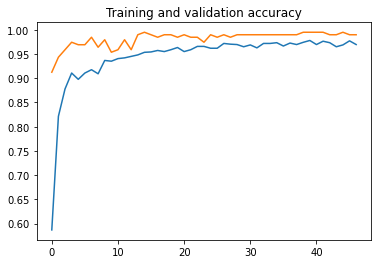

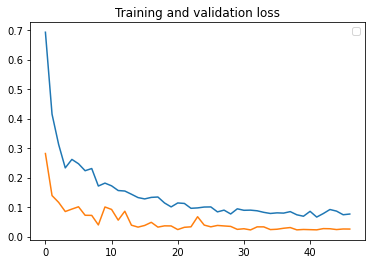

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc)
plt.plot  (epochs, val_acc)
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend()

In [16]:
model.save('my_model.h5')

# detector.py

In [18]:
my_model = tf.keras.models.load_model('my_model.h5')

results={0:'without mask',1:'mask'}
GR_dict={0:(0,0,255),1:(0,255,0)}

rect_size = 4
cap = cv2.VideoCapture(0) 


face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = cap.read()
    im=cv2.flip(im,1,1) 

    
    rerect_size = cv2.resize(im, (im.shape[1] // rect_size, im.shape[0] // rect_size))
    faces = face_cascade.detectMultiScale(
        rerect_size,
        scaleFactor=1.1,
        minNeighbors=3,
        flags=cv2.CASCADE_SCALE_IMAGE,
    )
    for f in faces:
        (x, y, w, h) = [v * rect_size for v in f] 
        
        face_img = im[y:y+h, x:x+w]
        rerect_sized=cv2.resize(face_img,(150,150))
        normalized=rerect_sized/255.0
        reshaped=np.reshape(normalized,(1,150,150,3))
        reshaped = np.vstack([reshaped])
        result=my_model.predict(reshaped)

        
        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(im,(x,y),(x+w,y+h),GR_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),GR_dict[label],-1)
        cv2.putText(im, results[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)

    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(10)
    
    if key == 27: 
        break

cap.release()

cv2.destroyAllWindows()